In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE

# Basic Structuring

In [3]:
harvard = pd.read_csv("data/Original Data/original_data.csv", sep=";")

print(harvard.shape)
# drop all non relevant questions
harvard = harvard.drop(columns=['grp', 'xsect'])
# drop all columns containing socio
# harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='socio')))]



# drop demographics but do not drop dem02 and dem03
dem02 = harvard['dem02']
dem03 = harvard['dem03']
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='dem')))]
harvard['dem02'] = dem02
harvard['dem03'] = dem03

# drop elig except elig02, elig03, to maybe get rid of: elig10, elig11, elig12, 
elig02, elig03, elig10, elig11, elig12 = harvard['Elig02'], harvard['Elig03'], harvard['Elig10'], harvard['Elig11'], harvard['Elig12']
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='Elig')))]
harvard['Elig02'], harvard['Elig03'], harvard['Elig10'], harvard['Elig11'], harvard['Elig12'] = elig02, elig03, elig10, elig11, elig12

# drop promis anger bank (EDANG)
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='EDANG')))]

# drop promis anxiety bank (EDANX)
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='EDANX')))]

# drop promis depression bank (EDDEP)
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='EDDEP')))]
 
# drop promis fatigue bank (FATIMP)
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='FATIMP')))]

# drop promis pain behaviour bank (PAINBE)
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='PAINBE')))]

# drop promis pain impact bank (PAININ)
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='PAININ')))]

# drop promis physical function bank (PFA, PFB, PFC)
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='PFA')))]
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='PFB')))]
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='PFC')))]

# promis social sat DSA bank (SRPSAT)
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='SRPSAT')))]

# promis social (SRPSAT)
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='SRPSOC')))]

# drop PSQI
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='PSQI')))]

# drop toflh
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='TOFLH')))]
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='toflh')))]

# drop FATEXP
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='FATEXP')))]

# drop BLIN, FLIN, Assmnt, Site
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='BLIN')))]
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='FLIN')))]
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='Assmnt')))]
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='Site')))]

# only keep the final sgrq score
sgrq_tot = harvard['sgrq_tot_r']
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='sgrq')))]
harvard['sgrq_tot_r'] = sgrq_tot


# drop all columns that are mostly empty

# TODO think about BCLIN3, BLIN4, "FCLINC", "BCLIN2" (contains two medication values)

# harvard = harvard.drop(columns=["FCLINB", "FCLINA",  "FCLIN9", "FCLIN7", "FCLIN4", "FCLIN2", "fclinra52", "FCLIN1", "BCLIN1", "BCLIN0", "FCLIN8", "FCLIN6", "FCLIN5", "FCLIN3", "BCLIN5", "BCLIN4", "BCLIN3", "FCLINC", "BCLIN2", "SGRQ11", "Unnamed: 949", "Unnamed: 950" ])
# drop all remaining columns containing "Bank" or 
harvard = harvard[harvard.columns.drop(list(harvard.filter(regex='Bank')))]

# drop dates
harvard = harvard.drop(columns=["bclinra01b", "bclinra02b", "bclinra05", "bclinra13", "bclinra15", "bclinra17"])

print(harvard.shape)

(2796, 926)
(2796, 336)


C:\Users\Daniel\AppData\Local\Temp\ipykernel_18472\3018542316.py:1: DtypeWarning: Columns (3,26,218,247,251) have mixed types. Specify dtype option on import or set low_memory=False.
  harvard = pd.read_csv("data/Original Data/original_data.csv", sep=";")


In [4]:
# create a baseline dataset (only the first record of each patient)

# get all unique values in the login column
unique_logins = harvard['login'].unique()
# baseline dataframe has the same columns as the original dataset
baseline = []
# create a follow up dataset (only the last record of each patient)
follow_up = []
for login in unique_logins:
    # add the first row of the selection to the baseline dataset
    baseline.append(harvard[harvard['login'] == login].iloc[0])

    # if there is more than 1 record per login
    if len(harvard[harvard['login'] == login]) > 1:
        # add the last row of the selection to the follow up dataset
        follow_up.append(harvard[harvard['login'] == login].iloc[-1])
# turn lists into dataframes but with columns from harvard dataset
baseline_df = pd.DataFrame(baseline, columns=harvard.columns)
follow_up_df = pd.DataFrame(follow_up, columns=harvard.columns)

# export baseline dataset
baseline_df.to_csv('baseline.csv', sep=";", index=False)
follow_up_df.to_csv('follow_up.csv', sep=";", index=False)
    


# Feature Space

C:\Users\Daniel\AppData\Local\Temp\ipykernel_19140\2873660330.py:5: DtypeWarning: Columns (24,157,481,483,484,486,487,503) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/dropped_variables.csv", sep=";")


COPD_group
ER_12m
ER_3m
doctor_3m
exa_12m
exa_2m
exa_in_study
hosp_12m
hosp_3m
stability_assistant
stability_physician


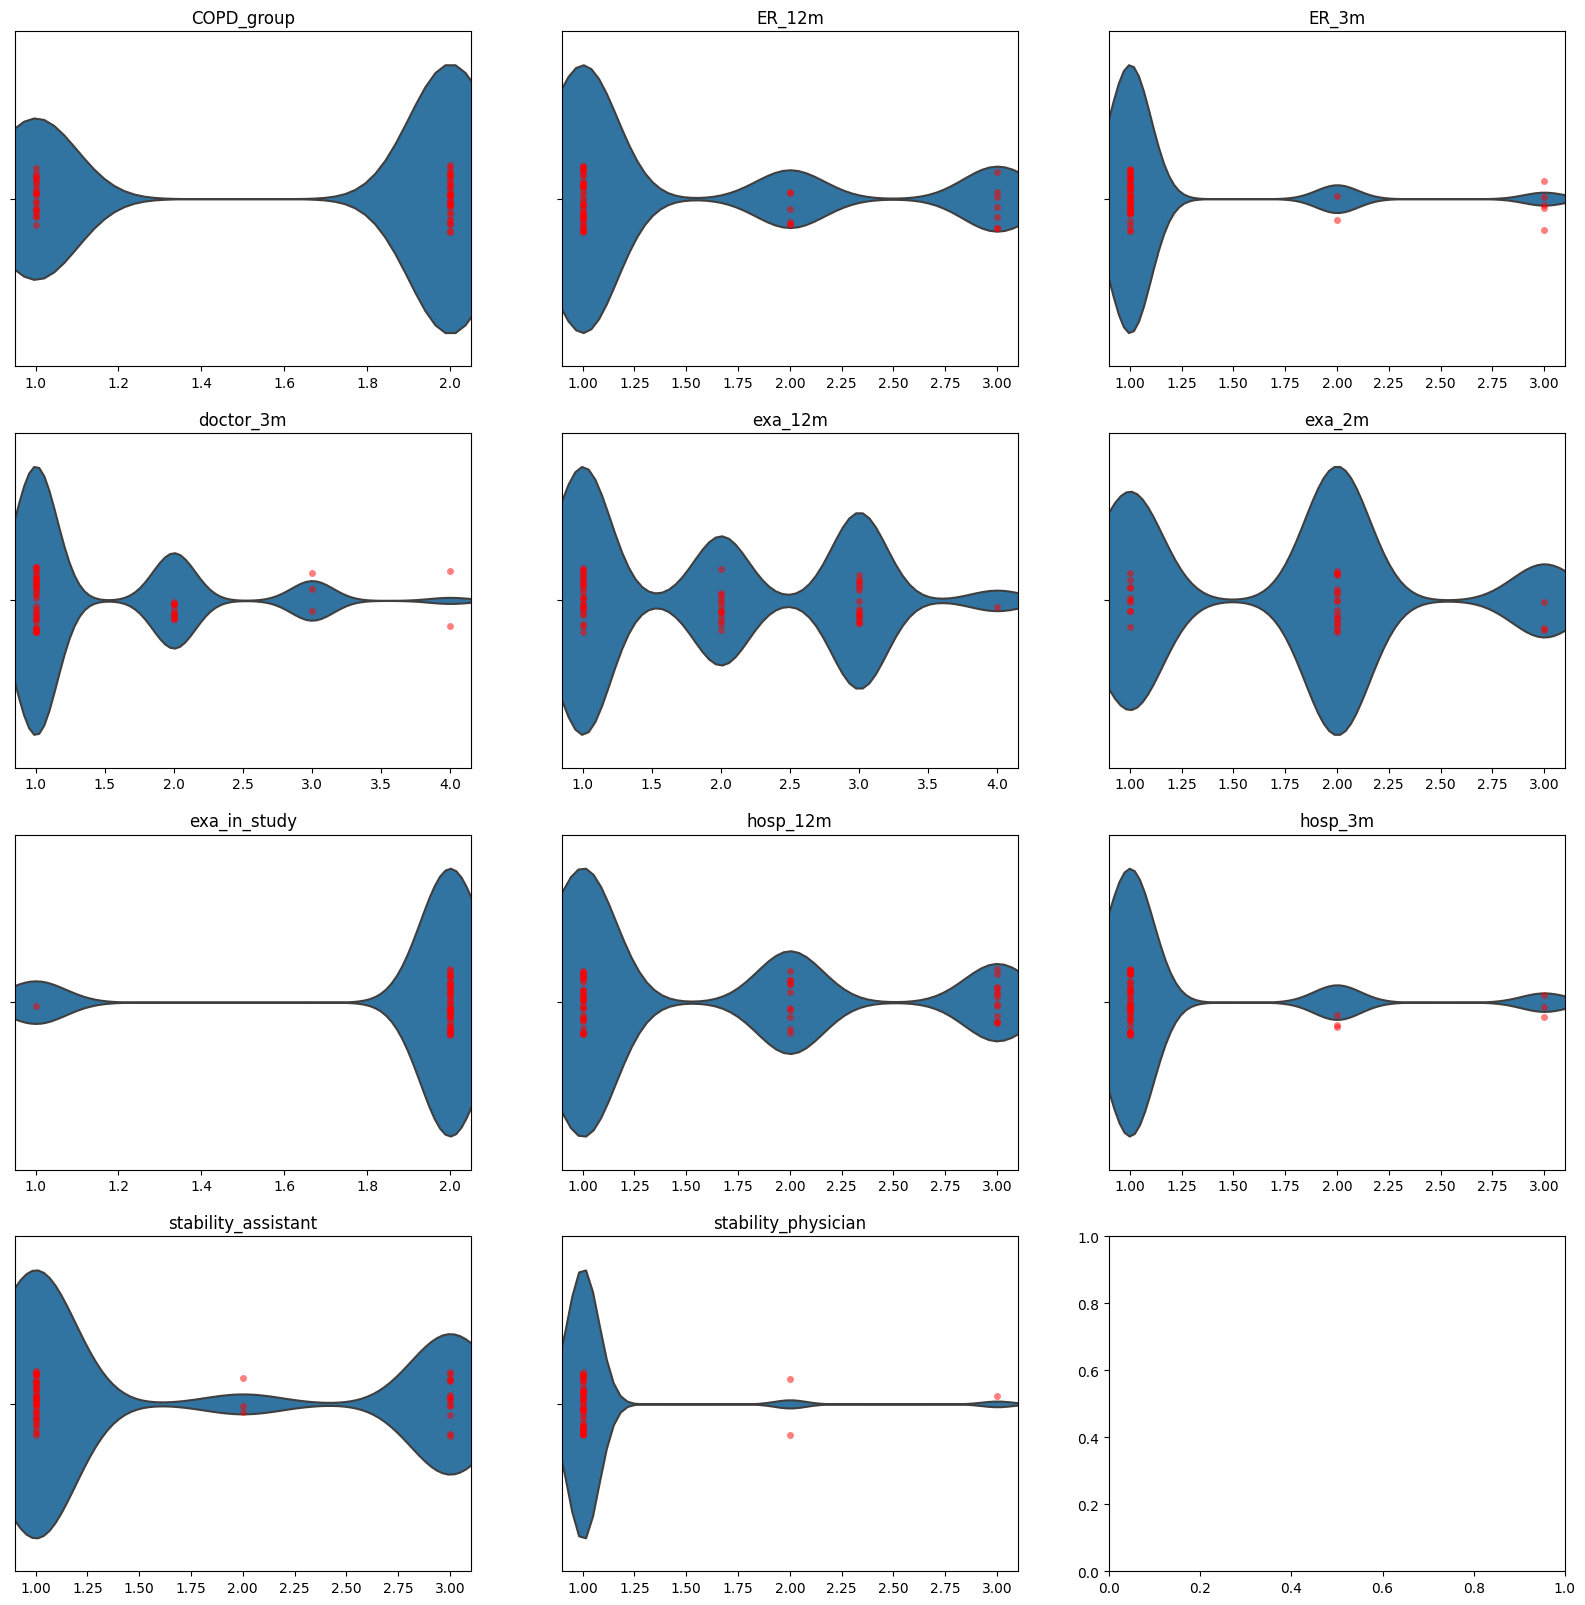

In [ ]:
import pandas as pd
import pandas_profiling

# investigate the correlations between all the possible target variables
data = pd.read_csv("data/dropped_variables.csv", sep=";")
target_vars = ["fclinra08", "bclinra07", "fclinra02", "fclinicpt03", "fclinpt04", "fclinpt05", "bclinpt24", "bclinpt26", "bclinpt22", "bclinpt23", "bclinra16"]
# create new dataframe with only target variables
targets_only = data[target_vars]
targets_only = targets_only.rename(columns={"fclinra08":"exa_in_study", "bclinra07":"stability_assistant", "fclinra02":"stability_physician", "fclinicpt03":"hosp_3m", "fclinpt04":"ER_3m", "fclinpt05":"doctor_3m", "bclinpt24":"hosp_12m", "bclinpt25":"hosp_2m", "bclinpt26":"ER_12m", "bclinpt27":"ER_2m", "bclinpt22":"exa_12m", "bclinpt23":"exa_2m", "bclinra16":"COPD_group"})
# sort columns
targets_only = targets_only.reindex(sorted(targets_only.columns), axis=1)

# # generate pandas profiling report with phik, spearman and pearson correlations
# report = pandas_profiling.ProfileReport(targets_only, correlations={"cramers": {"calculate": False}, "phi_k": {"calculate": True}, "spearman": {"calculate": True}, "pearson": {"calculate": True}})
# report.to_file("report_target_correlations.html")

# plot scatter plots between all pairs of target variables
# import seaborn as sns
# %matplotlib inline
# import matplotlib.pyplot as plt
# sns.pairplot(targets_only)
# plt.show()

# plot large vertical violin plots with samples superimposed for each target variable in one figure
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
# create figure
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
# iterate through all target variables
for i, target in enumerate(targets_only.columns):
    print(target)

    # get the current axis
    ax = axes[i//3, i%3]
    # plot violin plot withouth samples
    sns.violinplot(x=targets_only[target], ax=ax, inner=None)
    # remove 90% of the samples for each category
    reduced = targets_only[target].sample(frac=0.02)
    # show swarmplot
    # sns.swarmplot(x=targets_only[target], ax=ax, color="red", size=0.5)

    # plot samples using stripplot. Use entire height of the violin plot
    sns.stripplot(x=reduced, ax=ax, size=5, jitter=True, color="red", alpha=0.5)
    # only show ax title
    ax.set_xlabel("")

    # set title
    ax.set_title(target)
# save as svg
plt.savefig("images/harvard_targets_violin_plots.svg", format="svg")

# Preprocessing

In [5]:
# simple preprocessing like in Triage, Exaggerate
target = 'fclinra08' #'bclinpt24'

harvard = baseline_df

relevant_vars = ['dem02', 'dem03', 'bclinra01', 'bclinra02', 'bclinpt04', 'bclinpt15', 'mmrc', 'bclinpt07', 'bclinpt34',   'bclinpt28', target] #bclinpt19 (cancer), 'bclinpt36' fast breathing, 'bclinpt08', 'bclinpt09',

# load harvard dataset
harvard = harvard[relevant_vars]

# change mmrc by starting at 0 instead of 1
harvard['mmrc'] = harvard['mmrc'] - 1

# change gender by starting at 0 instead of 1
harvard['dem03'] = harvard['dem03'] - 1

# rename columns to common names with exaggerate
harvard = harvard.rename(columns={'dem02':'age', 'dem03': 'gender', 'bclinpt19': 'cancer', 'bclinpt04': 'hypertension', 'bclinpt15': 'diabetes', 'bclinpt07': 'heart_failure', target: 'target', 'bclinra01': 'height', 'bclinra02': 'weight', 'bclinpt34': 'fever',  'bclinpt08':'myocardial_infarct', 'bclinpt09':'stroke', 'bclinpt28':'dyspnoea', 'bclinpt36': 'fast_breathing',
 }) 
# print(harvard)

# swap variable for which yes and no are reversed (yes = 0, no = 1)
harvard['hypertension'] = 1 - harvard['hypertension']
harvard['diabetes'] = 1 - harvard['diabetes']
harvard['heart_failure'] = 1 - harvard['heart_failure']
harvard['fever'] = 1 - harvard['fever']
# harvard['fast_breathing'] = 1 - harvard['fast_breathing']

# calculate bmi from weight and height
harvard['bmi'] = harvard['weight'] / (harvard['height'] / 100) ** 2
harvard = harvard.drop(columns=['weight', 'height'])
harvard = harvard.reindex(sorted(harvard.columns), axis=1)

# plot_hist(harvard)

##########
# Missing Values & duplicates
##########

# remove all duplicate rows
# print("number of duplicates: " + str(harvard.duplicated().sum()))
harvard = harvard.drop_duplicates()
# print("number of duplicates after removal: " + str(harvard.duplicated().sum()))


# TODO try different imputation methods

numerical_vars = ['age', 'bmi']
for var in numerical_vars:
    harvard[var] = harvard[var].fillna(harvard[var].median())


# impute gender, cancer, hypertension, diabetes, heart_failure, target with most frequent value
categorical_vars = ['gender', 'hypertension', 'diabetes', 'heart_failure', 'target', 'mmrc', 'fever',   'dyspnoea'] # cancer, 'fast_breathing','myocardial_infarct','stroke', 
for var in categorical_vars:
    harvard[var] = harvard[var].fillna(harvard[var].mode()[0])

# print("empty cells remaining in the dataset")
# print(harvard.isnull().sum().sum())

# print("mv imputation")

# plot_hist(harvard)

##########
# Outliers
##########

# TODO deal with outliers

##########
# Feature engineering
############




# print("feature engineering")

# plot_hist(harvard)

##########
# Normalization
##########

numeric_vars = ['age', 'bmi', 'mmrc']
df_nr = harvard[numeric_vars]
df_rest = harvard.drop(columns=numeric_vars)
transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=harvard.index, columns=numeric_vars)
harvard= concat([tmp, df_rest], axis=1)


###########
# Target variable
###########

# print(harvard['target'].value_counts())
# if target variable is 1 then set it to 0, otherwise 1
harvard.loc[harvard['target'] == 1, 'target'] = 0
# set all none 0 values to 1
harvard.loc[harvard['target'] != 0, 'target'] = 1
# print(harvard['target'].value_counts())

# use smote to rebalance the harvard dataset in place
# print("perform smote")

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(harvard.drop(columns=['target']), harvard['target'])
X_res['target'] = y_res
harvard = X_res

# print(harvard['target'].value_counts())

# print("scaling, target variable, smote")

# plot_hist(harvard)


# sort the columns
harvard = harvard.reindex(sorted(harvard.columns), axis=1)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_18472\2471321215.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  harvard['mmrc'] = harvard['mmrc'] - 1
C:\Users\Daniel\AppData\Local\Temp\ipykernel_18472\2471321215.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  harvard['dem03'] = harvard['dem03'] - 1


In [91]:
# # take care of missing values in baseline dataset
# # print total missing values
# print(baseline_df.isnull().sum().sum())
# # drop all columns that contain more than 50% missing values
# baseline = baseline_df.dropna(thresh=baseline_df.shape[0]*0.5, how='all', axis=1)
# # drop all records where flcinra08 is missing
# baseline = baseline.dropna(subset=["fclinra08"])

# # drop variables that contain strings bclinpt44	bclinpt45 bclinra06a bclinpt41 bclinra201 psqi101
# baseline = baseline.drop(["bclinra06a"], axis=1)

# # replace all spaces with nan
# baseline = baseline.replace(r'^\s*$', np.nan, regex=True)
# # replace all values that contain "E+" with nan
# baseline = baseline.replace(r'^.*E\+.*$', np.nan, regex=True)

# # drop unnecessary columns 'bclinpt02', 'fclinra03', 'chart_bmi', 'sr_bmi', 'psqi01', 'psqi03 sr_ht_cm      bclinpt02_kg       weight_diff       height_diff
# baseline = baseline.drop(["bclinpt02", "fclinra03", "chart_bmi", "sr_bmi", "psqi01", "psqi03", "sr_ht_cm", "bclinpt02_kg", "weight_diff", "height_diff", "sgrq_tot_r"], axis=1)



# # get all numerical variables
# numerical = baseline.select_dtypes(include=['float64', 'int64'])

# # impute all categorical variables with the mode
# # for column in categorical.columns:
# #     baseline[column] = baseline[column].fillna(baseline[column].mode()[0])
# # impute all numerical variables with the median
# for column in numerical.columns:
#     baseline[column] = baseline[column].fillna(baseline[column].median())

# # find any string value. Do not rely on pandas object dtype
# for column in baseline.columns:
    


# # balance the dataset using smote
# from imblearn.over_sampling import SMOTE
# target = baseline["fclinra08"]
# # drop target variable from dataset
# baseline = baseline.drop("fclinra08", axis=1)
# # create smote object
# sm = SMOTE(random_state=42)
# # resample dataset
# baseline, target = sm.fit_resample(baseline, target)

# # create new dataframe with balanced dataset
# baseline = pd.concat([baseline, target], axis=1)

# print(baseline["fclinra08"].value_counts())

# # print missing values
# # print(baseline.isnull().sum().sum())

# # print variables with object dtype
# print(baseline.select_dtypes(include=['object']).columns)

16580
Index([], dtype='object')
2.00    126
1.00    126
Name: fclinra08, dtype: int64
Index([], dtype='object')


# Classification

In [9]:
from sklearn.svm import SVC

# target is fclinra08 (new exacerbation during study period)
target = harvard['target']

# drop target variable from dataset
classification_df = harvard.drop("target", axis=1)

# only keep age, bmi and mmrc
# classification_df = classification_df[['age', 'bmi', 'mmrc']]

# create train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(classification_df, target, test_size=0.3, random_state=42)
# convert to numpy array
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
# convert y_value to int
y_train = y_train.astype(int)
y_test = y_test.astype(int)

from lazypredict.Supervised import LazyClassifier

# # create lazy classifier
# clf = LazyClassifier(verbose=0, ignore_warnings=False, custom_metric=None)
# # fit model
# models, predictions = clf.fit(X_train, X_test, y_train, y_test)
# models

# import random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
# create random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# clf = SVC(kernel='linear', random_state=42, probability=True)

# fit model
clf.fit(X_train, y_train)
# predict on test set
y_pred = clf.predict(X_test)
# print accuracy
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# # visualize classifier using yellowbricks
# from yellowbrick.classifier import ClassificationReport
# # create classification report
# visualizer = ClassificationReport(clf, classes=['no exacerbation', 'exacerbation'], support=True)
# # fit model
# visualizer.fit(X_train, y_train)
# # evaluate model on test data
# visualizer.score(X_test, y_test)
# # show visualization
# visualizer.show()

#make it binary classification problem
X = X_train[np.logical_or(y_train==0,y_train==1)]
Y = y_train[np.logical_or(y_train==0,y_train==1)]


# # The equation of the separating plane is given by all x so that np.dot(svc.coef_[0], x) + b = 0.
# # Solve for w3 (z)
# z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]

# tmp = np.linspace(-5,5,30)
# x,y = np.meshgrid(tmp,tmp)

# fig = plt.figure()
# ax  = fig.add_subplot(111, projection='3d')
# ax.plot3D(X[Y==0,0], X[Y==0,1], X[Y==0,2],'ob')
# ax.plot3D(X[Y==1,0], X[Y==1,1], X[Y==1,2],'sr')
# ax.plot_surface(x, y, z(x,y))
# ax.view_init(30, 60)
# plt.show()

# harvard_feature_importances = {}
# features = list(harvard.drop(columns=['target']).columns)
# for i in range(len(features)):
#     harvard_feature_importances[features[i]] = []
# # fit a random forest classifier to the 'harvard' dataset
# for i in range(10):
#     X_train, X_test, y_train, y_test = train_test_split(harvard.drop(columns=['target']), harvard['target'], test_size=0.2)
#     clf.fit(X_train, y_train)
    
#     # add feature importances to dictionary
#     for feature, importance in zip(features, clf.feature_importances_):
#         if feature in harvard_feature_importances.keys():
#             harvard_feature_importances[feature].append(importance)
#         else:
#             harvard_feature_importances[feature] = [importance]
# fig, axs = plt.subplots(1, 3, figsize=(20, 20))
# for feature, importance in harvard_feature_importances.items():
#     axs[1].boxplot(importance, positions=[features.index(feature)])
# axs[1].set_xticklabels(features, rotation=90)
# axs[1].set_title('Harvard')

# print(harvard)

Accuracy: 0.8787878787878788


In [ ]:
# find out how many of the stable patients experienced an exacerbation within the 12 months

# find out how many of the unstable patients experienced and exacerbation within the 12 months


# find out how many patients dropped out